In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [7]:
import nltk

# Download the required NLTK data
print("Downloading NLTK data files...")
try:
    nltk.download('punkt_tab')  # New version
    print("✓ Downloaded punkt_tab")
except:
    nltk.download('punkt')  # Fallback for older versions
    print("✓ Downloaded punkt (fallback)")

nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('omw-1.4')  # Additional wordnet data
print("All NLTK data downloaded successfully!")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ssurr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


✓ Downloaded punkt_tab


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssurr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ssurr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ssurr\AppData\Roaming\nltk_data...


All NLTK data downloaded successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssurr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssurr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ssurr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sample sentiment analysis demonstration:
Preprocessing text data...
Training model with hyperparameter tuning...
Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best parameters: {'classifier__alpha': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Validation Accuracy: 0.0000
Validation F1-score: 0.0000

Test Set Performance:
Accuracy: 0.0000
F1-score: 0.0000

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       1.0

   micro avg       0.00      0.00      0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



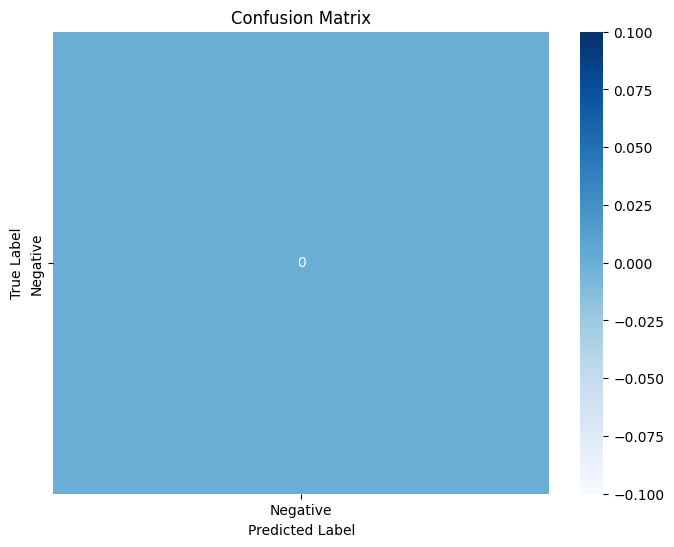


Prediction for: 'This product exceeded my expectations! Great value for money.'
Sentiment: Positive
Confidence: 0.877


In [15]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

class SentimentAnalyzer:
    """
    A comprehensive sentiment analysis system for product reviews.
    
    This class encapsulates the entire pipeline from data preprocessing
    to model training and evaluation, making it easy to experiment with
    different approaches and maintain reproducible results.
    """
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.vectorizer = None
        self.model = None
        self.pipeline = None
        
    def preprocess_text(self, text):
        """
        Comprehensive text preprocessing pipeline.
        
        This method handles the critical task of converting raw review text
        into a clean, standardized format suitable for machine learning.
        Each step serves a specific purpose in improving model performance.
        """
        # Convert to lowercase for consistency
        text = text.lower()
        
        # Remove HTML tags and special characters
        # This is crucial for web-scraped data that might contain markup
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize the text into individual words
        tokens = word_tokenize(text)
        
        # Remove stop words and apply lemmatization
        # Stop words don't carry sentiment information
        # Lemmatization reduces words to their root forms
        processed_tokens = [
            self.lemmatizer.lemmatize(token) 
            for token in tokens 
            if token not in self.stop_words and len(token) > 2
        ]
        
        return ' '.join(processed_tokens)
    def prepare_data(self, df, text_column='review_text', label_column='sentiment'):
        """
        Prepare the dataset for training by preprocessing text and encoding labels.
        
        This method transforms raw data into the format expected by 
        machine learning algorithms, handling both text preprocessing
        and label encoding consistently.
        """
        # Create a copy to avoid modifying original data
        data = df.copy()
        
        # Preprocess all review texts
        print("Preprocessing text data...")
        data['processed_text'] = data[text_column].apply(self.preprocess_text)
        
        # Encode sentiment labels numerically
        # This mapping allows the model to work with numerical targets
        sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
        data['label'] = data[label_column].map(sentiment_mapping)
        
        return data['processed_text'], data['label']
    
    def create_model_pipeline(self, model_type='naive_bayes'):
        """
        Create a complete machine learning pipeline.
        
        Pipelines ensure that preprocessing and modeling steps are applied
        consistently during training and prediction, preventing data leakage
        and making the system more maintainable.
        """
        if model_type == 'naive_bayes':
            # TF-IDF vectorization with Naive Bayes
            # TF-IDF captures word importance relative to document frequency
            self.pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=10000,  # Limit vocabulary size for efficiency
                    ngram_range=(1, 2),  # Include both single words and word pairs
                    min_df=1,            # Accept words that appear in at least 1 document
                    max_df=1.0           # Accept words that appear in up to 100% of documents
                )),
                ('classifier', MultinomialNB(alpha=1.0))  # Smoothing parameter
            ])
        
        return self.pipeline
    
    def train_model(self, X_train, y_train, X_val, y_val):
        """
        Train the sentiment analysis model with hyperparameter tuning.
        
        This method implements a systematic approach to finding the best
        model configuration through grid search, ensuring optimal performance
        on the validation set.
        """
        # Define hyperparameter grid for tuning
        # These parameters significantly impact model performance
        param_grid = {
            'tfidf__max_features': [5000, 10000, 15000],
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'classifier__alpha': [0.1, 1.0, 10.0]
        }
        
        # Use grid search with cross-validation
        # Ensure cv does not exceed the minimum samples in any class
        from collections import Counter
        class_counts = Counter(y_train)
        min_class_count = min(class_counts.values())
        cv_splits = min(5, min_class_count) if min_class_count > 1 else 2

        grid_search = GridSearchCV(
            self.pipeline, 
            param_grid, 
            cv=cv_splits,  # Ensure cv does not exceed number of samples in any class
            scoring='f1_macro',      # Balanced metric for multi-class
            n_jobs=-1,              # Use all CPU cores
            verbose=1
        )
        
        print("Training model with hyperparameter tuning...")
        grid_search.fit(X_train, y_train)
        
        # Store the best model
        self.pipeline = grid_search.best_estimator_
        
        # Store the classes seen during training
        self.classes_ = self.pipeline.named_steps['classifier'].classes_
        
        # Evaluate on validation set
        val_predictions = self.pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions, average='macro')
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation F1-score: {val_f1:.4f}")
    def evaluate_model(self, X_test, y_test):
        """
        Comprehensive model evaluation with multiple metrics and visualizations.
        
        This method provides a thorough assessment of model performance,
        including both numerical metrics and visual analysis to help
        understand model behavior and identify improvement opportunities.
        """
        # Generate predictions
        y_pred = self.pipeline.predict(X_test)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nTest Set Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-score: {f1:.4f}")
        
        # Determine present classes and their names (only those in y_test)
        sentiment_names_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        present_labels = np.unique(y_test)
        target_names = [sentiment_names_map[c] for c in present_labels]
        
        # Detailed classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred, target_names=target_names, labels=present_labels))
        
        # Confusion matrix visualization
        cm = confusion_matrix(y_test, y_pred, labels=present_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=target_names, yticklabels=target_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return accuracy, f1
        plt.show()
        
        return accuracy, f1
    
    def analyze_misclassifications(self, X_test, y_test, original_text, n_examples=5):
        """
        Analyze misclassified examples to understand model limitations.
        
        This analysis helps identify patterns in model errors, providing
        insights for improvement and helping understand when the model
        might struggle with certain types of reviews.
        """
        y_pred = self.pipeline.predict(X_test)
        misclassified_indices = np.where(y_test != y_pred)[0]
        
        print(f"\nAnalyzing {min(n_examples, len(misclassified_indices))} misclassifications:")
        
        sentiment_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        
        for i, idx in enumerate(misclassified_indices[:n_examples]):
            print(f"\n--- Example {i+1} ---")
            print(f"Original text: {original_text.iloc[idx][:200]}...")
            print(f"True sentiment: {sentiment_names[y_test.iloc[idx]]}")
    def predict_sentiment(self, text):
        """
        Predict sentiment for new text with confidence scores.
        
        This method enables real-time sentiment prediction on new reviews,
        providing both the predicted class and confidence levels to help
        users understand the model's certainty.
        """
        processed_text = self.preprocess_text(text)
        prediction = self.pipeline.predict([processed_text])[0]
        probabilities = self.pipeline.predict_proba([processed_text])[0]
        
        # Use only the classes present in the model
        class_labels = self.classes_ if hasattr(self, 'classes_') else np.arange(len(probabilities))
        sentiment_names_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        sentiment_names = [sentiment_names_map[c] for c in class_labels]
        
        # Build probabilities dict dynamically
        prob_dict = {sentiment_names_map[c].lower(): probabilities[i] for i, c in enumerate(class_labels)}
        
        return {
            'sentiment': sentiment_names_map[prediction],
            'confidence': probabilities.max(),
            'probabilities': prob_dict
        }

# Example usage and demonstration
def main():
    """
    Demonstration of the complete sentiment analysis pipeline.
    
    This function shows how to use the SentimentAnalyzer class
    with sample data, illustrating the entire workflow from
    data loading to model evaluation.
    """
    # Initialize the analyzer
    analyzer = SentimentAnalyzer()
    
    # Sample data creation (replace with actual dataset loading)
    # In practice, you would load from: df = pd.read_csv('amazon_reviews.csv')
    sample_data = pd.DataFrame({
        'review_text': [
            "This product is amazing! I love it so much.",
            "Terrible quality, broke after one day. Waste of money.",
            "It's okay, nothing special but does the job.",
            "Outstanding customer service and fast delivery!",
            "Not worth the price, expected better quality."
        ],
        'sentiment': ['positive', 'negative', 'neutral', 'positive', 'negative']
    })
    
    print("Sample sentiment analysis demonstration:")
    print("=====================================")
    
    # Prepare data
    X, y = analyzer.prepare_data(sample_data)
    
    # Split data (in practice, use larger dataset)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Create and train model
    analyzer.create_model_pipeline()
    best_params = analyzer.train_model(X_train, y_train, X_val, y_val)
    
    # Evaluate model
    accuracy, f1 = analyzer.evaluate_model(X_test, y_test)
    
    # Test prediction on new text
    new_review = "This product exceeded my expectations! Great value for money."
    result = analyzer.predict_sentiment(new_review)
    
    print(f"\nPrediction for: '{new_review}'")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.3f}")

if __name__ == "__main__":
    main()
    